# Fitting a Linear Model to Predict Vapor Pressure Deficit (VPD)
In this notebook, we fit a linear regression models using two different approaches: one where we fit a linear model directly on VPD, and one where we fit a linear model on the variables used to in calculating VPD, then computing VPD from there. We plot a fit of the predicted and actual VPD around San Diego to gauge model fit, then plot the differences of the predicted and actual VPD. 

In [1]:
#imports
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
from scipy.stats import distributions

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# functions to compute various NRMSEs
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('time')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [3]:
# computes t-test for differences
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

In [4]:
# compute vpd, given relative humidity and temperature
def get_vpd(humidity_data, tas_data):
    svp = 0.6112 * np.exp(17.76*(tas_data-273)/((tas_data-273) + 243.5))
    vpd = svp * (1 - humidity_data/100)
    return vpd

### Process Train/Test Data

We create the training and test data for our model. We train our model using 4 scenarios: historical, ssp126, ssp370, and ssp585, and test our model on ssp245. We use relative humidity and temperature to compute VPD. Our model uses global mean temperature as a predictor for VPD.

Side note: There are at least two formulas for saturation vapor pressure used in the computation of VPD that we found: $s_1(c) = 0.6112e^{17.76c/(c+243.5)}$ and $s_2(c) = 0.6107 \cdot 10^{7.5c/(c+237.3)}$. We use $s_1(c)$; one can show that for all reasonable temperatures, $s_1(c) = (s_2(c))^\gamma$ for some $\gamma \in [0.99,1.01]$ which depends on temperature. Thus, the formulas are roughly the same.

In [5]:
# scenarios used to train model
train_scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']

In [6]:
# load and compute VPD for train and test data
hursTrain = xr.concat([xr.open_dataset(f'vpd_data/hurs_{s}.nc') for s in train_scenarios]
    , dim='time')
tasTrain = xr.concat([xr.open_dataset(f'vpd_data/tas_{s}.nc') for s in train_scenarios]
    , dim='time')
vpdTrain = get_vpd(hursTrain.hurs, tasTrain.tas).to_dataset(name='vpd')

hursTest = xr.open_dataset('vpd_data/hurs_ssp245.nc')
tasTest = xr.open_dataset('vpd_data/tas_ssp245.nc')
vpdTest = get_vpd(hursTest.hurs, tasTest.tas).to_dataset(name='vpd')

C:\Users\kaits\anaconda3\Lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [7]:
# compute global mean temperature of training scenarios to use as a predictor in model
tempTrain = xr.concat(
    [xr.open_dataset(f'train_val/outputs_{s}.nc').mean('member') for s in train_scenarios]
    , dim='time')['tas']

# mean temp averaged globally and over training simulations
weights = np.cos(np.deg2rad(tempTrain.lat))
global_mean_temp = tempTrain.weighted(weights).mean(['lat', 'lon']).to_numpy().reshape(-1,1)

In [8]:
# compute global mean temperature of teset scenarios to make predictions
tempTest = xr.open_dataset(f'test/outputs_ssp245.nc')['tas'].mean('member')

# get mean temperature averaged globally
test_input = (tempTest
              .weighted(weights)
              .mean(['lat', 'lon'])
              .to_pandas() # convert to pandas to use rolling average
              .rolling(10, min_periods=1)
              .mean()
              .to_numpy() # convert back to numpy to reshape
              .reshape(-1,1))

### Fit Linear Regression Models
Firstly, we fit a linear model, called *model_vpd*, which are trained on and directly predict VPD. We also fit two linear models, called *model_hurs* and *model_tas*, which are trained on and predict relative humidity and temperature data. We then compute VPD predictions by computing VPD from the predicted relative humidity and temperature.

In [9]:
# fit model on VPD
# need to fit intercept
model_vpd = LinearRegression(fit_intercept=True)
model_vpd.fit(global_mean_temp, vpdTrain.vpd.stack(dim=['lat','lon']))

# get predictions
output_vpd = model_vpd.predict(test_input).reshape(86,96,144)

In [10]:
model_vpd.coef_, model_vpd.intercept_

(array([[3.57647311e-05],
        [2.75922975e-05],
        [2.31950541e-05],
        ...,
        [8.86175643e-03],
        [8.87046437e-03],
        [8.87874739e-03]]),
 array([-1.36189003e-05, -3.32942150e-05, -4.41187943e-05, ...,
        -9.94688532e-03, -9.95693505e-03, -9.96457907e-03]))

In [11]:
# fit model on humidity
model_hurs = LinearRegression(fit_intercept=True)
model_hurs.fit(global_mean_temp, hursTrain.hurs.stack(dim=['lat','lon']))

# fit model on temperature
model_tas = LinearRegression(fit_intercept=True)
model_tas.fit(global_mean_temp, tasTrain.tas.stack(dim=['lat','lon']))

# get humidity and temperature predictions
output_hurs = model_hurs.predict(test_input).reshape(86,96,144)
output_tas = model_tas.predict(test_input).reshape(86,96,144)

# compute VPD
output_postvpd = get_vpd(output_hurs, output_tas)

### Evaluate Model
We evalute our model by compute the NRMSE as defined in the ClimateBench paper. The label *vpd_direct* denotes the NRMSEs of our first approach of directly predicting VPD, and the label *vpd_indirect* denotes the NRMSEs of our second approach of computing VPD from relative humidity and temperature predictions. We see that the NRMSE of our first approach is lower, which means that the linear model performs better when trained directly on VPD.

In [12]:
nrmses = [
    [
        get_nrmse_spatial(vpdTest.vpd, out), 
        get_nrmse_global(vpdTest.vpd, out),
        get_nrmse(vpdTest.vpd, out)
    ] 
    for out in [output_vpd, output_postvpd]
]

nrmse_table = pd.DataFrame(
    data=nrmses, 
    index=['vpd_direct', 'vpd_indirect'], 
    columns=['spatial', 'global', 'total']
).round(3)

nrmse_table

,spatial,global,total
vpd_direct,0.036,0.012,0.096
vpd_indirect,0.040,0.016,0.122


### Plot True vs. Predictions at San Diego
From here on out, we adopt the model of our first approach (predicting VPD directly). We create a scatter plot of the predicted VPD vs. the true VPD at San Diego from the years 2080-2100 to gauge our model fit.

In [13]:
# turn output into dataarray to plot
xr_output=xr.Dataset(
    coords={'time': vpdTest.time.values, 'lat': vpdTest.lat.values, 'lon': vpdTest.lon.values})

xr_output['vpd'] = (['time', 'lat', 'lon'], output_vpd)

In [14]:
# san diego location is (lat = 32.7W, lon = 117.6N)
sd_lat = xr_output.lat[65]
sd_lon = xr_output.lon[97] # 360-117.6
sd_lat.data, sd_lon.data

(array(33.15789474), array(242.5))

In [15]:
# function to get VPD from 2080-2100 in San Diego
def get_sd_VPD(vpd_data):
    return vpd_data.loc[dict(lat=sd_lat,lon=sd_lon)].sel(time=slice(2080,2100))['vpd'].data

In [16]:
# get predictions and actual VPD at San Diego
sd_pred = get_sd_VPD(xr_output)
sd_actual = get_sd_VPD(vpdTest)

In [17]:
# years for looking at San Diego VPD
years = list(range(2080,2101))

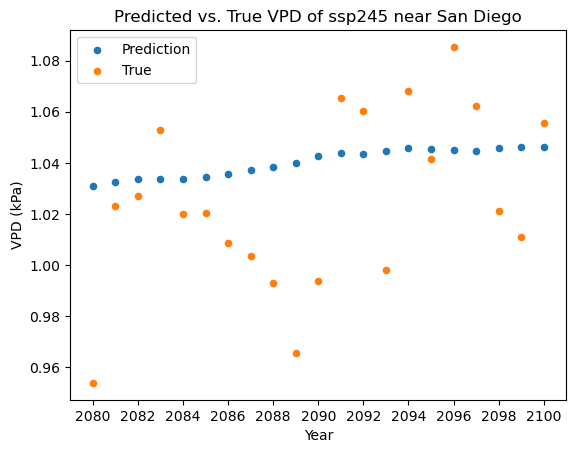

In [18]:
# create scatter plot
plt.scatter(years,sd_pred,s=20,label='Prediction')
plt.scatter(years,sd_actual,s=20,label='True')
plt.xticks(list(range(2080,2101,2)))
plt.xlabel('Year')
plt.ylabel('VPD (kPa)')
plt.title('Predicted vs. True VPD of ssp245 near San Diego')
plt.legend();

Lastly, we plot the predicted, true, and differences in VPD averaged over 2080-2100. In our difference plot, we leave areas with statistically insignificant ($p <0.05$) differences white. Visually, it is extremely hard to tell a difference from the predicted and true plot. However, given that only a small amount of the difference plot is left white, this means that many of the differences between the predicted and true VPD are statistically significant.

In [19]:
# variables used in plotting
p_level = 0.05
proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-4, vmax=4), dict(vmin=-4, vmax=4), dict(vmin=-0.2, vmax=0.2), dict(vmin=-20, vmax=20)]
titles = ['Predicted', 'True', 'Differences', 'Percent Error']

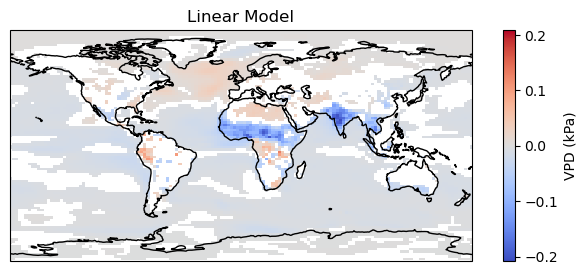

In [34]:
plt.figure(figsize=(8, 3))
ax = plt.axes(projection=proj)
plt.title("Linear Model")
diff = xr_output - vpdTest
diff = diff['vpd'][-21:]
mean_time = diff.mean('time')
_, p = ttest_rel_from_stats(mean_time, diff.std('time'), diff.count('time'))
mean_time = mean_time.where(p<p_level)
(mean_time.plot(ax=ax,
                         cmap="coolwarm", 
                         add_labels=False, 
                         transform=ccrs.PlateCarree(), 
                         cbar_kwargs={"label":"VPD (kPa)", "orientation":'vertical'}))

ax.coastlines()
#plt.savefig("Linear.pdf")

<xarray.DataArray 'vpd' (lat: 96, lon: 144)>
array([[ 482.37697909,  -42.26847638,   22.91748851, ..., -104.06588489,
        1882.01304234,  264.40125411],
       [  18.06856726,   20.93323652,   17.904298  , ...,   17.9667137 ,
          16.65551548,   15.74279735],
       [ -22.95618888,  -31.15928086,  -91.16539168, ...,  -30.21548016,
         -42.07884722,  -29.3690999 ],
       ...,
       [  60.93313646,   59.78823672,   57.93388081, ...,   66.90680734,
          63.69658038,   60.97451601],
       [  67.85347797,   67.47670891,   67.15675267, ...,   70.17563156,
          68.85513427,   68.12326262],
       [  66.45563037,   66.50763938,   66.6545926 , ...,   66.51167387,
          66.47885663,   66.4442099 ]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5


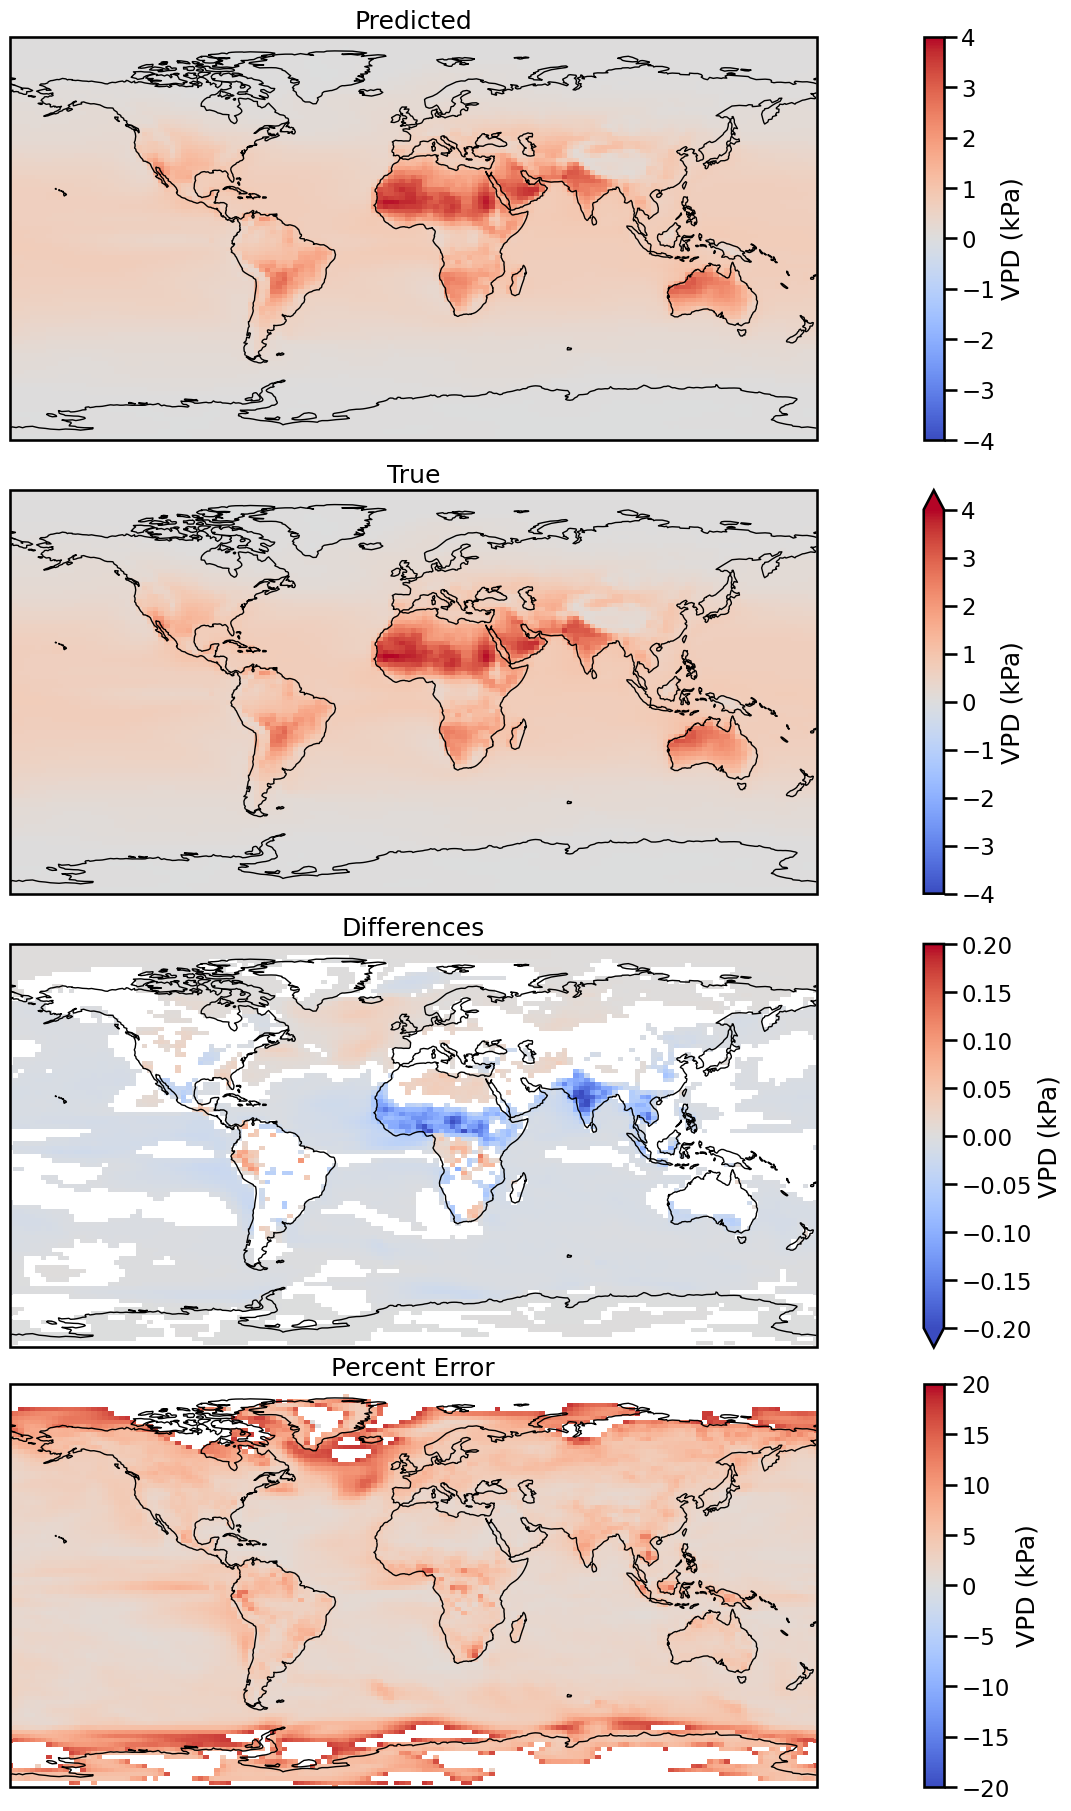

In [35]:
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(4, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    diff = xr_output - vpdTest
    errors = np.abs(diff) * 100 / vpdTest
    plot_data = [xr_output, vpdTest, diff, errors]
    for i in range(4):
        ax = axes[i]
        data = plot_data[i]['vpd'][-21:]
        kws = kwargs[i]
        title = titles[i]
        
        ax.set_title(title)
        mean_time = data.mean('time')
        # only show regions with statistically significant difference
        # when plotting differences
        if i == 2:
            _, p = ttest_rel_from_stats(mean_time, data.std('time'), data.count('time'))
            #print(p)
            mean_time = mean_time.where(p<p_level)
        
        if i == 3:
            print(mean_time)
            mean_time = mean_time.where(np.array(mean_time) < 18).where(np.array(mean_time) > 0)
            (mean_time.plot(
                         cmap="coolwarm", 
                         ax=ax, 
                         add_labels=False, 
                         transform=ccrs.PlateCarree(), 
                         cbar_kwargs={"label":"VPD (kPa)", "orientation":'vertical'},
                         **kws))
        else:
            (mean_time.plot(
                         cmap="coolwarm", 
                         ax=ax, 
                         add_labels=False, 
                         transform=ccrs.PlateCarree(), 
                         cbar_kwargs={"label":"VPD (kPa)", "orientation":'vertical'},
                         **kws))
        ax.coastlines()